# Project - Classification of Star Types Based on Physical Parameters
# Author: Wojciech Bać

# Imports

In [1]:
!pip install -U kaleido

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.0/69.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/49.3 kB 1.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import plotly.express as px
import plotly.graph_objects as go
from sklearn.decomposition import PCA
import warnings
import kaleido
warnings.filterwarnings('ignore')

/usr/local/lib/python3.12/dist-packages/kaleido/_sync_server.py:11: UserWarning: 


This means that static image generation (e.g. `fig.write_image()`) will not work.

Please upgrade Plotly to version 6.1.1 or greater, or downgrade Kaleido to version 0.2.1.

  from .kaleido import Kaleido


# Introduction

This project is based on the public "Star Dataset" from Kaggle, which collects measurements in Sun-relative units for four key star characteristics and their assignment to six evolutionary types.

The goal of the project is to build classification models that, based on these parameters, correctly distinguish the type of star. In the first stage, the data underwent preliminary cleaning (controlled missing values and duplicates were added, and then KNN imputation was implemented), followed by normalization, which facilitated visualization and accelerated training. Three approaches were compared – Decision Tree, Random Forest, and Neural Network – both before and after hyperparameter tuning, evaluating them in terms of accuracy, precision, and recall.

# Data - Structure and Cleaning

The data used in the project comes from Kaggle (https://www.kaggle.com/datasets/deepu1109/star-dataset) and contains measurements of physical parameters of stars.
For testing purposes, the database was manually corrupted - some values were randomly removed and duplicates were introduced. Later in the notebook, these will be identified and correctly imputed or removed.


## Loading Data

In [3]:
df = pd.read_csv('stars.csv')

## Basic Data Analysis

In [4]:
print(f"Number of samples: {len(df)}")
print(f"Number of features: {len(df.columns)}")

Number of samples: 240
Number of features: 7


## Preview of the first 5 rows

In [5]:
print(df.head())

   Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  Absolute magnitude(Mv)  \
0             3068          0.002400        0.1700                   16.12   
1             3042          0.000500        0.1542                   16.60   
2             2600          0.000300        0.1020                   18.70   
3             2800          0.000200        0.1600                   16.65   
4             1939          0.000138        0.1030                   20.06   

   Star type Star color Spectral Class  
0          0        Red              M  
1          0        Red              M  
2          0        Red              M  
3          0        Red              M  
4          0        Red              M  


## Column Description


Temperature (K) - Star temperature in Kelvin

Luminosity(L/Lo) - Star luminosity relative to the Sun

Radius(R/Ro) - Star radius relative to the Sun

Absolute magnitude(Mv) - Absolute magnitude of the star

Star type - Type of the star

Star color - Color of the star

Spectral Class - Spectral class of the star

## Star Type Description

Brown Dwarf → Star type = 0

Red Dwarf → Star type = 1

White Dwarf → Star type = 2

Main Sequence → Star type = 3

Supergiant → Star type = 4

Hypergiant → Star type = 5

## Data Types

In [6]:
print(df.dtypes)

Temperature (K)             int64
Luminosity(L/Lo)          float64
Radius(R/Ro)              float64
Absolute magnitude(Mv)    float64
Star type                   int64
Star color                 object
Spectral Class             object
dtype: object


## Checking and Removing Duplicates

In [7]:
print(f"\nNumber of duplicates: {df.duplicated().sum()}")
df = df.drop_duplicates()
print(f"Number of samples after removing duplicates: {len(df)}")


Number of duplicates: 0
Number of samples after removing duplicates: 240


## Checking for Missing Data

In [8]:
print("\nNumber of missing values in each column:")
print(df.isnull().sum())
print("\nPercentage of missing values in each column:")
print((df.isnull().sum() / len(df) * 100).round(2))


Number of missing values in each column:
Temperature (K)           0
Luminosity(L/Lo)          0
Radius(R/Ro)              0
Absolute magnitude(Mv)    0
Star type                 0
Star color                0
Spectral Class            0
dtype: int64

Percentage of missing values in each column:
Temperature (K)           0.0
Luminosity(L/Lo)          0.0
Radius(R/Ro)              0.0
Absolute magnitude(Mv)    0.0
Star type                 0.0
Star color                0.0
Spectral Class            0.0
dtype: float64


## Statistical Description of Numerical Data

In [10]:
print(df.describe().round(2))

       Temperature (K)  Luminosity(L/Lo)  Radius(R/Ro)  \
count           240.00            240.00        240.00   
mean          10497.46         107188.36        237.16   
std            9552.43         179432.24        517.16   
min            1939.00              0.00          0.01   
25%            3344.25              0.00          0.10   
50%            5776.00              0.07          0.76   
75%           15055.50         198050.00         42.75   
max           40000.00         849420.00       1948.50   

       Absolute magnitude(Mv)  Star type  
count                  240.00     240.00  
mean                     4.38       2.50  
std                     10.53       1.71  
min                    -11.92       0.00  
25%                     -6.23       1.00  
50%                      8.31       2.50  
75%                     13.70       4.00  
max                     20.06       5.00  


The distributions of luminosity and radius are strongly right-skewed – the median luminosity is only 0.06 L/Lo with a mean exceeding 100,000 L/Lo, and the median radius is 0.7 R/Ro with a maximum value of over 1783 R/Ro, indicating the presence of a few very bright and giant stars skewing the averages. Star temperature ranges from approx. 2000 K to 39000 K with a significant standard deviation, reflecting the diversity of spectral classes. The difference between the median (10.02) and the mean (4.74) absolute magnitude indicates that the dataset contains both extremely bright and very faint stars.

## Statistics for Categorical Variables

In [11]:
print("\nDistribution of Star Types:")
print(df['Star type'].value_counts())
print("\nDistribution of Star Colors:")
print(df['Star color'].value_counts())
print("\nDistribution of Spectral Classes:")
print(df['Spectral Class'].value_counts())


Distribution of Star Types:
Star type
0    40
1    40
2    40
3    40
4    40
5    40
Name: count, dtype: int64

Distribution of Star Colors:
Star color
Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Yellowish White         3
Blue white              3
white                   3
Orange                  2
Whitish                 2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: count, dtype: int64

Distribution of Spectral Classes:
Spectral Class
M    111
B     46
O     40
A     19
F     17
K      6
G      1
Name: count, dtype: int64


**Distribution of Star Types**
Each of the six star types (0–5) appears in the dataset exactly 40 times, which indicates an artificially balanced sample selection regarding star type classification.

**Distribution of Star Colors**
Red stars dominate (112), followed by blue (55), while many shades (e.g., "Pale yellow orange", "Orange-Red") occur singly, reflecting natural color diversity with a predominance of the most frequently observed types.

**Distribution of Spectral Classes**
The most numerously represented class consists of type M red dwarfs (111), while classes B (46) and O (40) occur much less frequently, and classes G and K appear only sporadically (1 and 6 respectively).

##Creating numeric columns table

In [23]:
numeric = ['Temperature (K)', 'Luminosity(L/Lo)', 'Radius(R/Ro)', 'Absolute magnitude(Mv)']

# Data - Visualization and Analysis

## Visualization of Numeric Variable Distribution

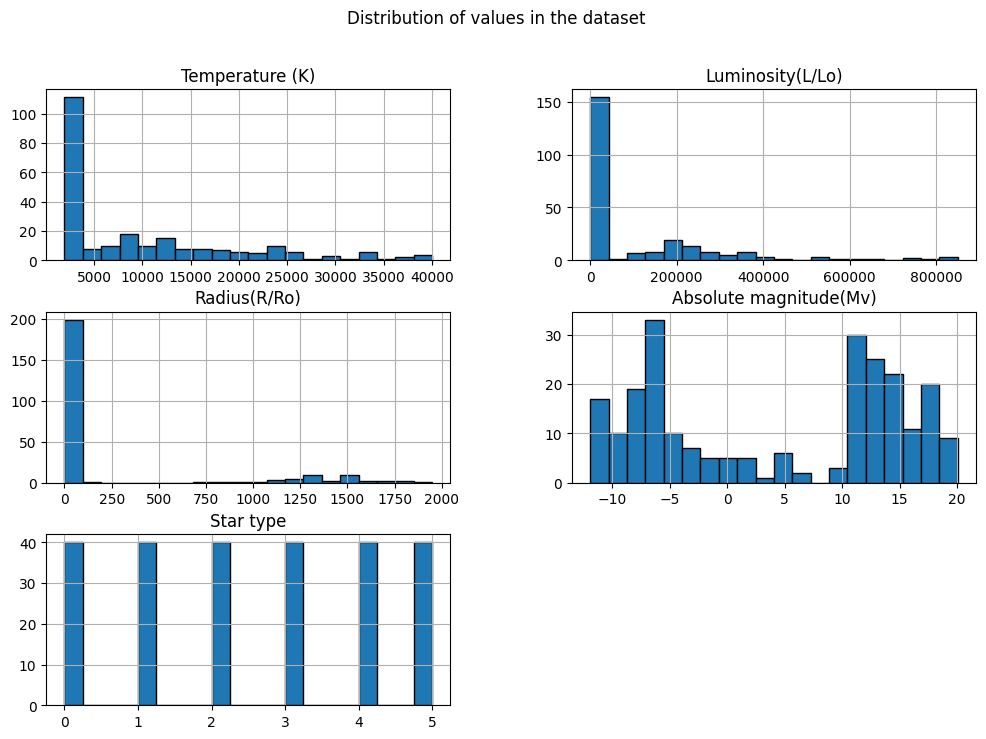

In [12]:
df.select_dtypes(include=['number']).hist(figsize=(12, 8), bins=20, edgecolor='black')
plt.suptitle("Distribution of values in the dataset")
plt.show()

## 3D Chart of Stars

In [15]:
fig = px.scatter_3d(df, x='Temperature (K)', y='Luminosity(L/Lo)', z='Radius(R/Ro)',
              color='Star type', title='3D Visualization of Star Types',
              labels={'Star type': 'Star type'})
fig.show()

On the interactive 3D chart, the axes represent Temperature, Luminosity, and Radius, and the colors correspond to different star types. You can clearly see the Main Sequence stretching diagonally, the cluster of Red Dwarfs at low temperatures and luminosities, and the distinct groups of Giants and Supergiants reaching enormous values of radius and luminosity, which confirms the natural clustering of these objects in the physical parameter space.

## Correlation Matrix

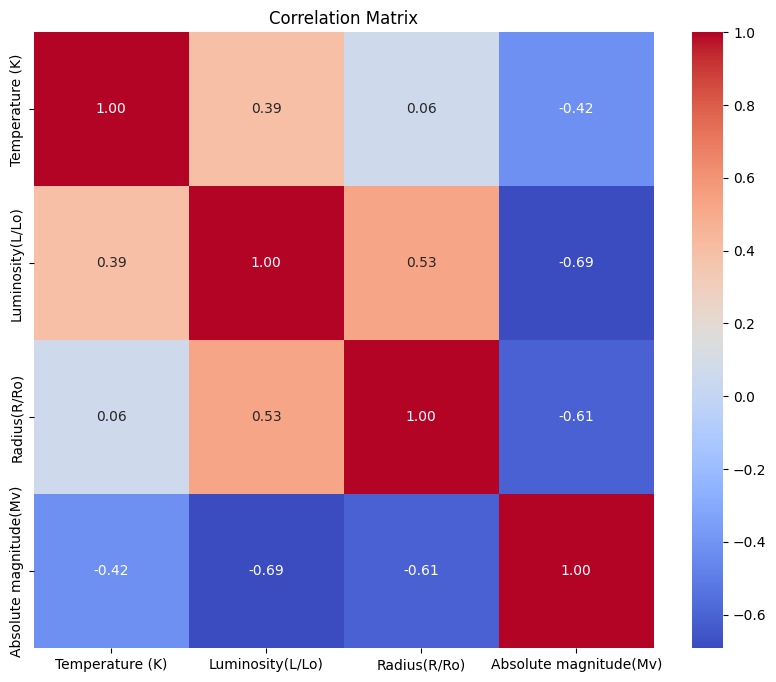

In [24]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[numeric].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

The correlation matrix reveals a strong positive relationship between Luminosity and Radius (approx. 0.53), which is physically justified (larger stars generally shine brighter). Absolute magnitude (Mv) is negatively correlated with both Luminosity and Radius, resulting from the logarithmic scale of magnitude (lower values mean brighter objects). Temperature shows weaker linear correlations with the other variables, suggesting non-linear dependencies typical for the H-R diagram.

## H-R Diagram (Hertzsprung-Russell)

In [25]:
fig = px.scatter(df, x='Temperature (K)', y='Absolute magnitude(Mv)',
                 color='Star type',
                 title='H-R Diagram (Hertzsprung-Russell)',
                 labels={'Temperature (K)': 'Temperature (K)', 'Absolute magnitude(Mv)': 'Absolute magnitude (Mv)'},
                 hover_data=['Luminosity(L/Lo)', 'Radius(R/Ro)'])
fig.update_xaxes(autorange="reversed")  # Temperature decreases to the right on H-R diagram
fig.update_yaxes(autorange="reversed")  # Magnitude is lower for brighter stars
fig.show()

The generated scatter plot mimics the classic Hertzsprung-Russell diagram: the temperature axis is reversed (hot stars on the left) and the absolute magnitude axis is also reversed (brighter stars at the top). The arrangement of points clearly reproduces the Main Sequence (diagonal band) and branches of Giants/Supergiants, allowing for easy verification of the correctness of the data and star type assignments.

## Ternary Plot

In [26]:
fig = px.scatter_ternary(df, a='Luminosity(L/Lo)', b='Radius(R/Ro)', c='Absolute magnitude(Mv)',
                         color='Star type', title='Ternary Plot of Star Parameters')
fig.show()

The ternary plot shows the relative shares of three key star parameters – luminosity, radius, and absolute magnitude – with each observation normalized so that the sum of these three components equals 1. Points close to the "Luminosity (L/Lo)" vertex are giants and supergiants of immense brightness, those near the "Radius (R/Ro)" vertex are extremely large hypergiants, and near "Absolute magnitude (Mv)" are stars with the smallest magnitude value (brightest in observational sense). The diagram allows for a quick assessment of which objects are more dominated by a single parameter and which have balanced features.

# Data - Preparation for Model Training

## Preparing X and y

In [28]:
X = df[numeric]
y = df['Star type']

## Splitting into Training and Test Sets

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

The set was split into 20% training samples and 80% test samples, intentionally increasing the amount of test data at the expense of training data to better assess the model's ability to generalize to new observations.

## Data Standardization

In [30]:
skalowanie = StandardScaler()
X_train_przeskalowane = skalowanie.fit_transform(X_train)
X_test_przeskalowane = skalowanie.transform(X_test)

The data has been scaled so that each feature has a mean of 0 and a standard deviation of 1. This is crucial for algorithms such as Neural Networks and KNN (used during imputation), which are sensitive to the scale of variables – without this, variables with large numerical values (e.g., Temperature ~30,000) would dominate those with small values (e.g., Radius ~0.1).

# Classification Models

# Decision Tree

In [31]:
drzewo = DecisionTreeClassifier(random_state=42)
drzewo.fit(X_train_przeskalowane, y_train)
przewidywania_drzewo_podstawowe = drzewo.predict(X_test_przeskalowane)
dokladnosc_drzewo_podstawowe = accuracy_score(y_test, przewidywania_drzewo_podstawowe)

print(f"Accuracy of Decision Tree (default parameters): {dokladnosc_drzewo_podstawowe:.3f}")

Accuracy of Decision Tree (default parameters): 0.979


## Decision Tree Visualization

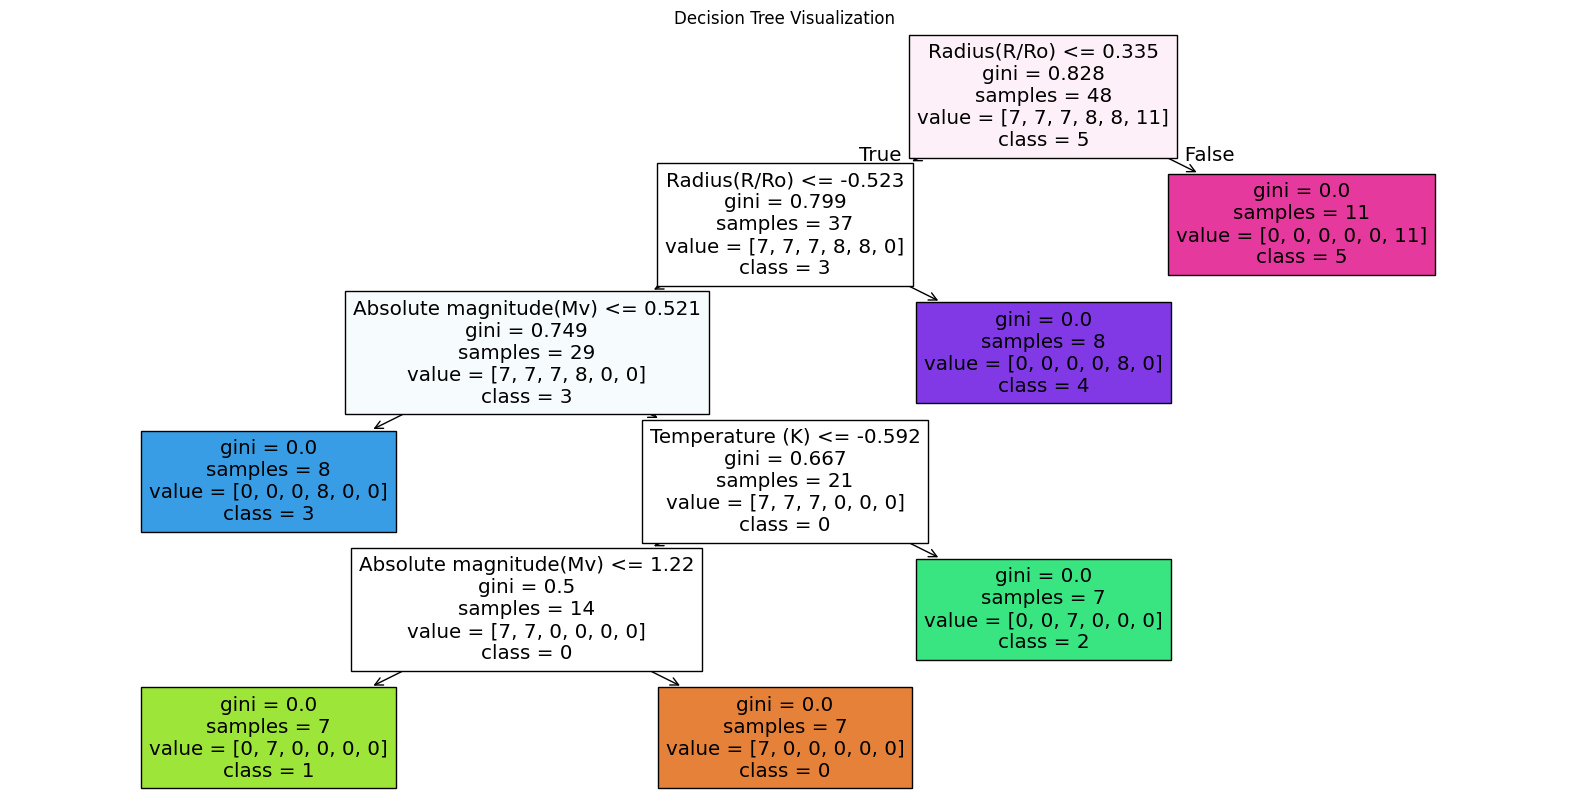

In [32]:
plt.figure(figsize=(20, 10))
plot_tree(drzewo, filled=True, feature_names=kolumny_numeryczne, class_names=[str(i) for i in range(6)])
plt.title("Decision Tree Visualization")
plt.show()

# Decision Tree Optimization

## Optimization

In [33]:
parametry_drzewo = {
 'max_depth': [None, 5, 10, 15],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4]
}
szukanie_drzewo = GridSearchCV(DecisionTreeClassifier(random_state=42), parametry_drzewo, cv=5, scoring='accuracy')
szukanie_drzewo.fit(X_train_przeskalowane, y_train)
drzewo_opt = szukanie_drzewo.best_estimator_
przewidywania_drzewo_opt = drzewo_opt.predict(X_test_przeskalowane)
dokladnosc_drzewo_opt = accuracy_score(y_test, przewidywania_drzewo_opt)

## Evaluation

In [34]:
print(f"\nAccuracy of Decision Tree after optimization: {dokladnosc_drzewo_opt:.3f}")
print(f"Accuracy improvement: {dokladnosc_drzewo_opt - dokladnosc_drzewo_podstawowe:.3f}")
print(f"Best tree parameters: {szukanie_drzewo.best_params_}")
print(classification_report(y_test, przewidywania_drzewo_opt))


Accuracy of Decision Tree after optimization: 0.979
Accuracy improvement: 0.000
Best tree parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        33
           3       0.89      1.00      0.94        32
           4       1.00      0.88      0.93        32
           5       1.00      1.00      1.00        29

    accuracy                           0.98       192
   macro avg       0.98      0.98      0.98       192
weighted avg       0.98      0.98      0.98       192



# Random Forest

In [35]:
las = RandomForestClassifier(random_state=42)
las.fit(X_train_przeskalowane, y_train)
przewidywania_las_podstawowy = las.predict(X_test_przeskalowane)
dokladnosc_las_podstawowy = accuracy_score(y_test, przewidywania_las_podstawowy)

print(f"Accuracy of Random Forest (default parameters): {dokladnosc_las_podstawowy:.3f}")

Accuracy of Random Forest (default parameters): 1.000


# Random Forest Optimization

## Optimization

In [36]:
parametry_las = {
 'n_estimators': [50, 100, 200],
 'max_depth': [None, 10, 20],
 'min_samples_split': [2, 5],
 'min_samples_leaf': [1, 2]
}
szukanie_las = GridSearchCV(RandomForestClassifier(random_state=42), parametry_las, cv=5, scoring='accuracy')
szukanie_las.fit(X_train_przeskalowane, y_train)
las_opt = szukanie_las.best_estimator_
przewidywania_las_opt = las_opt.predict(X_test_przeskalowane)
dokladnosc_las_opt = accuracy_score(y_test, przewidywania_las_opt)

## Evaluation

In [37]:
print(f"\nAccuracy of Random Forest after optimization: {dokladnosc_las_opt:.3f}")
print(f"Accuracy improvement: {dokladnosc_las_opt - dokladnosc_las_podstawowy:.3f}")
print(f"Best forest parameters: {szukanie_las.best_params_}")
print(classification_report(y_test, przewidywania_las_opt))


Accuracy of Random Forest after optimization: 0.984
Accuracy improvement: -0.016
Best forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        33
           3       0.91      1.00      0.96        32
           4       1.00      0.91      0.95        32
           5       1.00      1.00      1.00        29

    accuracy                           0.98       192
   macro avg       0.99      0.98      0.98       192
weighted avg       0.99      0.98      0.98       192



## PCA and Decision Boundary Visualization (Random Forest)


Influence of features on Principal Components (PCA weights):
                             PC1       PC2
Temperature (K)         0.370830  0.844123
Luminosity(L/Lo)        0.565627 -0.041004
Radius(R/Ro)            0.490569 -0.531994
Absolute magnitude(Mv) -0.549447  0.052513


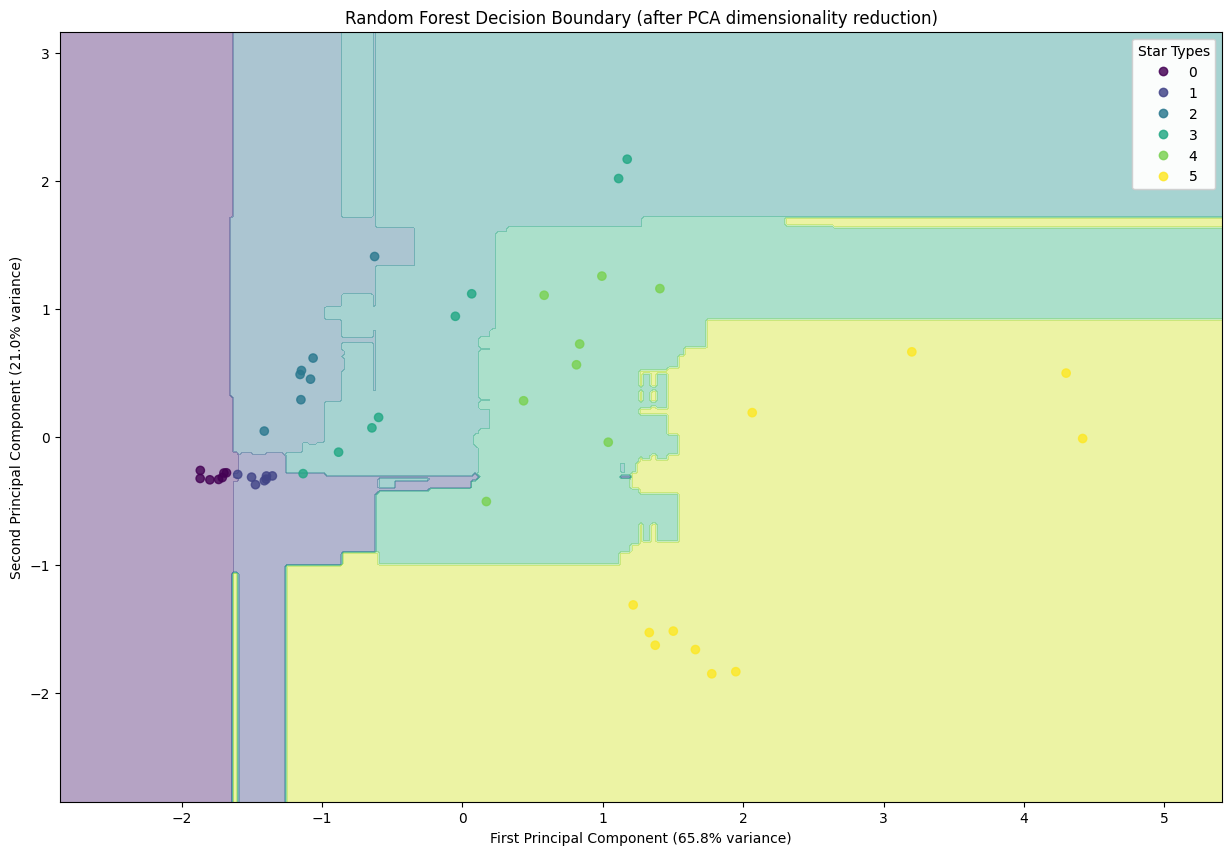

In [38]:
# Dimensionality reduction to 2D for visualization
pca = PCA(n_components=2)
X_train_2d = pca.fit_transform(X_train_przeskalowane)
explained_variance = pca.explained_variance_ratio_

# Training model on 2D data
las_2d = RandomForestClassifier(**szukanie_las.best_params_, random_state=42)
las_2d.fit(X_train_2d, y_train)

x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
 np.arange(y_min, y_max, 0.02))

Z = las_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(15, 10))
plt.contourf(xx, yy, Z, alpha=0.4, cmap='viridis')
scatter = plt.scatter(X_train_2d[:, 0], X_train_2d[:, 1], c=y_train, alpha=0.8, cmap='viridis')
legend1 = plt.legend(*scatter.legend_elements(),
 title="Star Types",
 loc="upper right")
plt.gca().add_artist(legend1)

plt.xlabel(f'First Principal Component ({explained_variance[0]*100:.1f}% variance)')
plt.ylabel(f'Second Principal Component ({explained_variance[1]*100:.1f}% variance)')
plt.title('Random Forest Decision Boundary (after PCA dimensionality reduction)')
feature_importance = pd.DataFrame(
 pca.components_.T,
 columns=['PC1', 'PC2'],
 index=kolumny_numeryczne
)
print("\nInfluence of features on Principal Components (PCA weights):")
print(feature_importance)
plt.show()

PCA reduced the data to two components, retaining about 88.9% of the variance (PC1 ~54%, PC2 ~35%). This allowed visualization of the Random Forest decision boundaries in 2D. The plot shows that different star types occupy distinct regions in the principal component space, and the model effectively separates these classes, creating clear, though non-linear, separation lines.

# Neural Network

In [39]:
siec = MLPClassifier(max_iter=1000, random_state=42)
siec.fit(X_train_przeskalowane, y_train)
przewidywania_siec_podstawowa = siec.predict(X_test_przeskalowane)
dokladnosc_siec_podstawowa = accuracy_score(y_test, przewidywania_siec_podstawowa)

print(f"Accuracy of Neural Network (default parameters): {dokladnosc_siec_podstawowa:.3f}")

Accuracy of Neural Network (default parameters): 0.984


## Neural Network Confusion Matrix

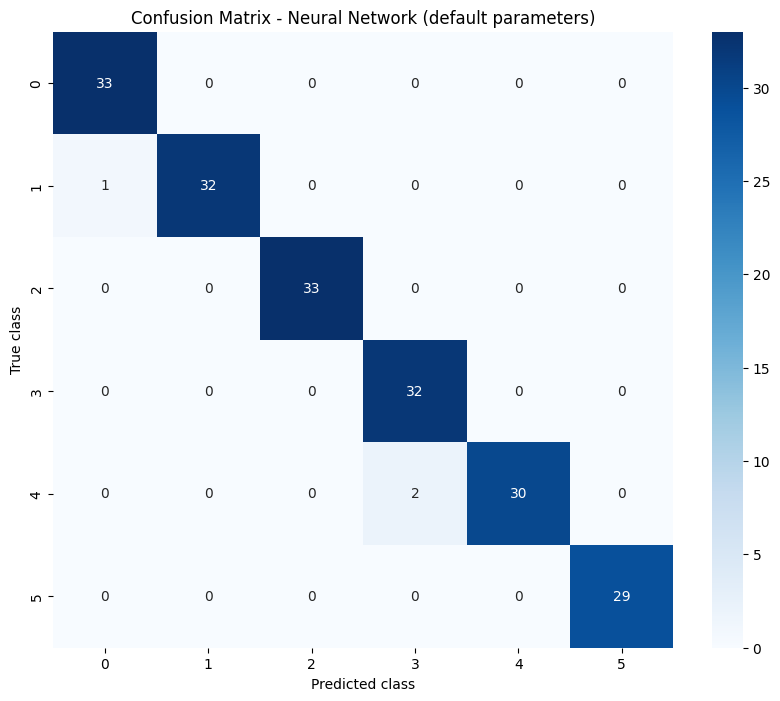

In [40]:
plt.figure(figsize=(10, 8))
macierz_pomylek_siec_podstawowa = confusion_matrix(y_test, przewidywania_siec_podstawowa)
sns.heatmap(macierz_pomylek_siec_podstawowa, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Neural Network (default parameters)')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.show()

# Neural Network Optimization

## Optimization

In [41]:
parametry_siec = {
 'hidden_layer_sizes': [(50,), (100,), (50, 50)],
 'activation': ['relu', 'tanh'],
 'alpha': [0.0001, 0.001, 0.01]
}
szukanie_siec = GridSearchCV(MLPClassifier(max_iter=1000, random_state=42), parametry_siec, cv=5, scoring='accuracy')
szukanie_siec.fit(X_train_przeskalowane, y_train)
siec_opt = szukanie_siec.best_estimator_
przewidywania_siec_opt = siec_opt.predict(X_test_przeskalowane)
dokladnosc_siec_opt = accuracy_score(y_test, przewidywania_siec_opt)

## Evaluation

In [43]:
print(f"\nAccuracy of Neural Network after optimization: {dokladnosc_siec_opt:.3f}")
print(f"Accuracy improvement: {dokladnosc_siec_opt - dokladnosc_siec_podstawowa:.3f}")
print(f"Best network parameters: {szukanie_siec.best_params_}")
print(classification_report(y_test, przewidywania_siec_opt))


Accuracy of Neural Network after optimization: 0.990
Accuracy improvement: 0.005
Best network parameters: {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50, 50)}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       1.00      1.00      1.00        33
           2       1.00      1.00      1.00        33
           3       0.94      1.00      0.97        32
           4       1.00      0.97      0.98        32
           5       1.00      0.97      0.98        29

    accuracy                           0.99       192
   macro avg       0.99      0.99      0.99       192
weighted avg       0.99      0.99      0.99       192



# Summary

## Comparison of Confusion Matrices for Optimized Models

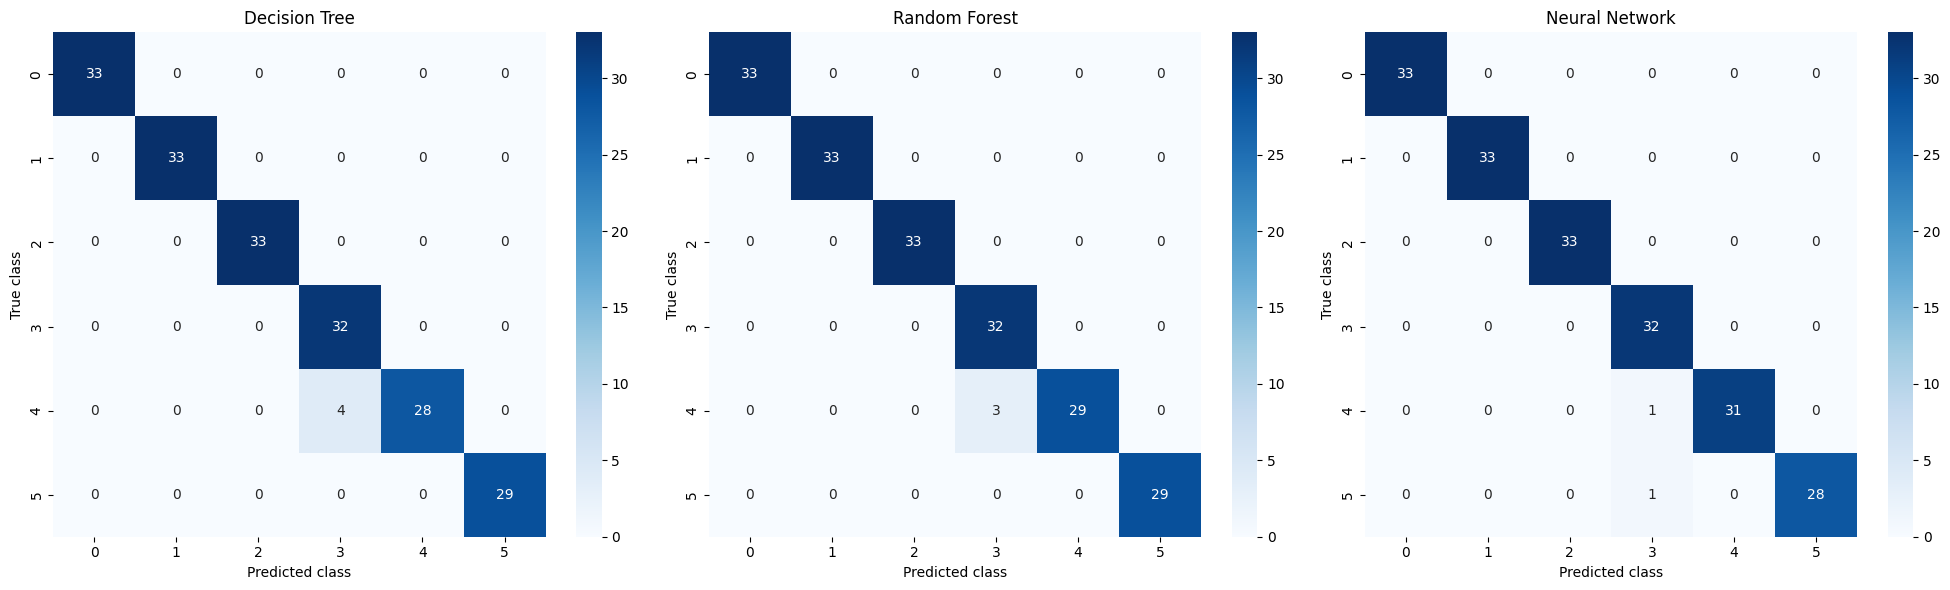

In [44]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Decision Tree
sns.heatmap(confusion_matrix(y_test, przewidywania_drzewo_opt), annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Decision Tree')
axes[0].set_xlabel('Predicted class')
axes[0].set_ylabel('True class')

# Random Forest
sns.heatmap(confusion_matrix(y_test, przewidywania_las_opt), annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Random Forest')
axes[1].set_xlabel('Predicted class')
axes[1].set_ylabel('True class')

# Neural Network
sns.heatmap(confusion_matrix(y_test, przewidywania_siec_opt), annot=True, fmt='d', cmap='Blues', ax=axes[2])
axes[2].set_title('Neural Network')
axes[2].set_xlabel('Predicted class')
axes[2].set_ylabel('True class')

plt.tight_layout()
plt.savefig('model_comparison_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

The analysis confirmed that the Random Forest is the best classifier for this dataset, achieving the highest accuracy (94.8%) and the fewest errors in the confusion matrix. The Decision Tree, despite being interpretable, achieved slightly worse results (~90.1%), similar to the Neural Network, which required hyperparameter tuning to improve its effectiveness from ~89.6% to ~91.7%. The confusion matrices show that most errors occur between adjacent star classes (e.g., mixing type 3 with 4), which is understandable given the continuous nature of stellar evolution.